# Loading the data

In [642]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

The data is from this [Kaggle page](https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results).

In [599]:
data_filename = 'mxmh_survey_results.csv'
survey_data = pd.read_csv(data_filename, parse_dates=True)

In [600]:
print(survey_data.columns)
survey_data.head()

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Permissions'],
      dtype='object')


,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


We are most interested in using the musical data to predict the psychological/physiological illnesses: depression, OCD, insomnia, and anxiety. Many of the categorical columns contain binary (yes/no) or spectrum (e.g. frequency) data. These columns particularly lend themselves well to ordinal encoding. We'll use one hot encoding to handle the other categorical columns.

## Spliting the training data

In [601]:
from sklearn.model_selection import train_test_split

y = survey_data.Depression
X = survey_data.drop(['Depression', 'Insomnia', 'OCD', 'Anxiety'], axis=1)

X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(X, y, random_state=7)

<hr/>

# Cleaning
## Looking for missing values

In [602]:
print(X_train_full.shape)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()]
print(cols_with_missing)

missing_val_counts = X_train_full.isnull().sum()
print(missing_val_counts[missing_val_counts > 0])

(552, 29)
['Age', 'Primary streaming service', 'While working', 'Instrumentalist', 'Foreign languages', 'BPM', 'Music effects']
Age                           1
Primary streaming service     1
While working                 1
Instrumentalist               2
Foreign languages             3
BPM                          75
Music effects                 5
dtype: int64


Because this data originates from a survey, many left the BPM measuring heart rate question blank. With how often this occurs, it seems reasonable to drop this column in training the model. The other columns rarely have missing values, and it seems reasonable to impute them.

In [603]:
X_train = X_train_full.drop(['BPM', 'Timestamp'], axis=1)
X_valid = X_valid_full.drop(['BPM', 'Timestamp'], axis=1)
y_train = y_train_full
y_valid = y_valid_full

## Imputing missing values

In [604]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [605]:
num_cols = ['Age']
cat_cols = ['Primary streaming service', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Music effects']

X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].mean())
X_valid[num_cols] = X_valid[num_cols].fillna(X_train[num_cols].mean())

X_train[cat_cols] = X_train[cat_cols].fillna(X_train[cat_cols].mode().iloc[0])
X_valid[cat_cols] = X_valid[cat_cols].fillna(X_train[cat_cols].mode().iloc[0])


## Dealing with categorical columns

In [606]:
obj_cols = X_train.select_dtypes(include=[object]).columns

In [607]:
d = {col: X_train[col].nunique() for col in obj_cols}
sorted(d.items(), key=lambda x: x[1])

[('Permissions', 1),
 ('While working', 2),
 ('Instrumentalist', 2),
 ('Composer', 2),
 ('Exploratory', 2),
 ('Foreign languages', 2),
 ('Music effects', 3),
 ('Frequency [Classical]', 4),
 ('Frequency [Country]', 4),
 ('Frequency [EDM]', 4),
 ('Frequency [Folk]', 4),
 ('Frequency [Gospel]', 4),
 ('Frequency [Hip hop]', 4),
 ('Frequency [Jazz]', 4),
 ('Frequency [K pop]', 4),
 ('Frequency [Latin]', 4),
 ('Frequency [Lofi]', 4),
 ('Frequency [Metal]', 4),
 ('Frequency [Pop]', 4),
 ('Frequency [R&B]', 4),
 ('Frequency [Rap]', 4),
 ('Frequency [Rock]', 4),
 ('Frequency [Video game music]', 4),
 ('Primary streaming service', 6),
 ('Fav genre', 16)]

The number of unique values in the 'Fav genre' field indicates that we should consider removing this column when modeling. With over 15 types of favorite genres, this field is unlikely to work well with one-hot encoding. Since the entries don't form a spectrum, ordinal encoding is also inappropriate.

In [608]:
X_train = X_train.drop(['Fav genre'], axis=1)
X_valid = X_valid.drop(['Fav genre'], axis=1)

We need to ensure that the ColumnTransformer we'll eventually apply doesn't remove the numerical columns. We'll operate on these columns by scaling them to zero mean and variance 1.

In [609]:
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

In [610]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [611]:
del d['Fav genre']
del d['Primary streaming service']

freq_cols = [col for col in d.keys() if col.startswith('Frequency')]
freq_cats = ['Very frequently', 'Sometimes', 'Rarely', 'Never']
for col in freq_cols:
    del d[col]

del d['Music effects']
effects_cats = ['Improve', 'No effect', 'Worsen']

ordinal_cols = list(d.keys())
#onehot_cols = ['Primary streaming service', 'Fav genre']
onehot_cols = ['Primary streaming service']

cat_processor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('freq', OrdinalEncoder(categories=[freq_cats for _ in range(len(freq_cols))]), freq_cols),
        ('effects', OrdinalEncoder(categories=[effects_cats]), ['Music effects']),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
        ('scaler', StandardScaler(), num_cols)
    ]
)

<hr />

# Modeling

In [612]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

In [613]:
prelim_models = [LinearRegression(), RandomForestRegressor(random_state=7), XGBRegressor()]
steps = [('cat_processor', cat_processor), None]
pipelines = []

for i, model in enumerate(prelim_models):
    steps.pop()
    steps.append((f'model[{i}]', model))
    pipelines.append(Pipeline(steps=steps.copy()))

In [614]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [615]:
for i, pipe in enumerate(pipelines):
    scores = -1 * cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    print(f'Model[{i}] score: {scores.mean()}')

Model[0] score: 9.258313044262229
Model[1] score: 8.76258123955774
Model[2] score: 10.349187578713504


We ran the code with and without the 'Fav genre' field and found that linear regression does better without it, while random forests and gradient boosting do slightly worse without it. Dropping the column will simplify our model a bit, leading to less overfitting, and keeping it doesn't gain much, so we'll drop it.

Without additional hyperparameter/feature tuning, we notice that random forests does the best, then linear regression in second, and gradient boosting doing the worst.

## Hyperparameter tuning: random forests

In [616]:
from sklearn.model_selection import GridSearchCV

In [617]:
n_estimators = list(range(50, 350, 50))
min_samples_split = [2, 5, 10, 12]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]

grid = {'n_estimators': n_estimators,
         'min_samples_split': min_samples_split,
         'min_samples_leaf': min_samples_leaf,
         'bootstrap': bootstrap
}

In [618]:
rf = RandomForestRegressor(random_state=7)
grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=3)

In [619]:
rf_pipe = Pipeline(
    steps=[('cats', cat_processor),
           ('grid', grid_search)]
)

#rf_pipe.fit(X_train, y_train)
#rf_pipe['grid'].best_params_

The grid search finished in 2.5 minutes. We obtain the following hyperparameters:
 - 'bootstrap': True,
 - 'min_samples_leaf': 4,
 - 'min_samples_split': 10,
 - 'n_estimators': 200

In [620]:
rf_hyperparams = {'bootstrap': True,
                  'min_samples_leaf': 4,
                  'min_samples_split': 10,
                  'n_estimators': 200
}

rf_pipe_final = Pipeline(
    steps=[('cats', cat_processor),
           ('rf', RandomForestRegressor(random_state=7, **rf_hyperparams))]
)

scores = -1 * cross_val_score(rf_pipe_final, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
scores.mean()

8.680601898580154

Using the tuned hyperparameters gives about a .21 improvement in the mean squared error for random forests.

## Hyperparameter tuning: gradient boosting

In [621]:
from sklearn.model_selection import RandomizedSearchCV

In [622]:
n_estimators = list(range(100, 1100, 100))
learning_rate = np.arange(.1, .25, 0.05)
min_child_weight = [1, 5 ,10]
gamma = [0.5, 1, 1.5, 2, 5]
subsample = [0.6, 0.8, 1.0]
colsample_bytree = [0.6, 0.8, 1]
max_depth = [3, 4, 5]

grid = {'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth,
}

In [623]:
xgb = XGBRegressor()
grid_search = RandomizedSearchCV(estimator=xgb, param_distributions=grid, cv=5, n_iter=100, n_jobs=-1)

In [624]:
xgb_pipe = Pipeline(
    steps=[('cat', cat_processor),
           ('grid', grid_search)]
)

#xgb_pipe.fit(X_train, y_train)
#xgb_pipe['grid'].best_params_

In [625]:
grid = {
    'subsample': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 150],
    'min_child_weight': [9, 10, 11],
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1],
    'gamma': [0.75, 1.0, 1.25],
    #'cosample_bytree': [0.5, 0.6]
}

In [626]:
grid_search = GridSearchCV(estimator=xgb, param_grid=grid, cv=3, n_jobs=-1)

In [627]:
xgb_pipe = Pipeline(
    steps=[('cat', cat_processor),
           ('grid', grid_search)]
)

xgb_pipe.fit(X_train, y_train)
xgb_pipe['grid'].best_params_

{'gamma': 0.75,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 11,
 'n_estimators': 50,
 'subsample': 0.9}

We obtain the following hyperparameters for gradient boost:
 - 'cosample_bytree': 0.5,
 - 'gamma': 0.75,
 - 'learning_rate': 0.1,
 - 'max_depth': 2,
 - 'min_child_weight': 11,
 - 'n_estimators': 50,
 - 'subsample': 0.9}

In [628]:
xgb_hyperparams = {#'cosample_bytree': 0.5,
 'gamma': 0.75,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 11,
 'n_estimators': 50,
 'subsample': 0.9}

xgb_pipe_final = Pipeline(
    steps=[('cat', cat_processor),
           ('xgb', XGBRegressor(n_jobs=-1, **xgb_hyperparams))]
)

scores = -1 * cross_val_score(xgb_pipe_final, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
scores.mean()

8.642196689995023

We obtain a massive improvement of about 1.7 in the mean squared error after hyperparameter tuning.

After all this, we notice thta gradient boost performs slightly better than random forests. Because the difference is so small and random forests offer more interpretable results, we'll still opt to use random forests.

## Final model

In [629]:
final_pipe = rf_pipe_final
final_pipe.fit(X_train, y_train)
preds = final_pipe.predict(X_valid)
mean_squared_error(y_valid, preds)

8.756928334829883

In [649]:
feature_names = final_pipe['cats'].get_feature_names_out()
rem_strs = ['scaler__', 'freq__', 'effects__', 'ord__']
for i, feature in enumerate(feature_names):
    for substr in rem_strs:
        if feature.startswith(substr):
            feature_names[i] = feature.replace(substr, '')
            continue
        elif feature.startswith('onehot__'):
            feature_names[i] = feature.replace('onehot__Primary streaming service_', 'Primary: ')
            continue

wts = final_pipe['rf'].feature_importances_
wtd_features = pd.DataFrame(wts, index=feature_names)
wtd_features.columns = ['weights']
wtd_features = wtd_features.sort_values(by='weights', ascending=False)

Text(0, 0.5, 'Feature')

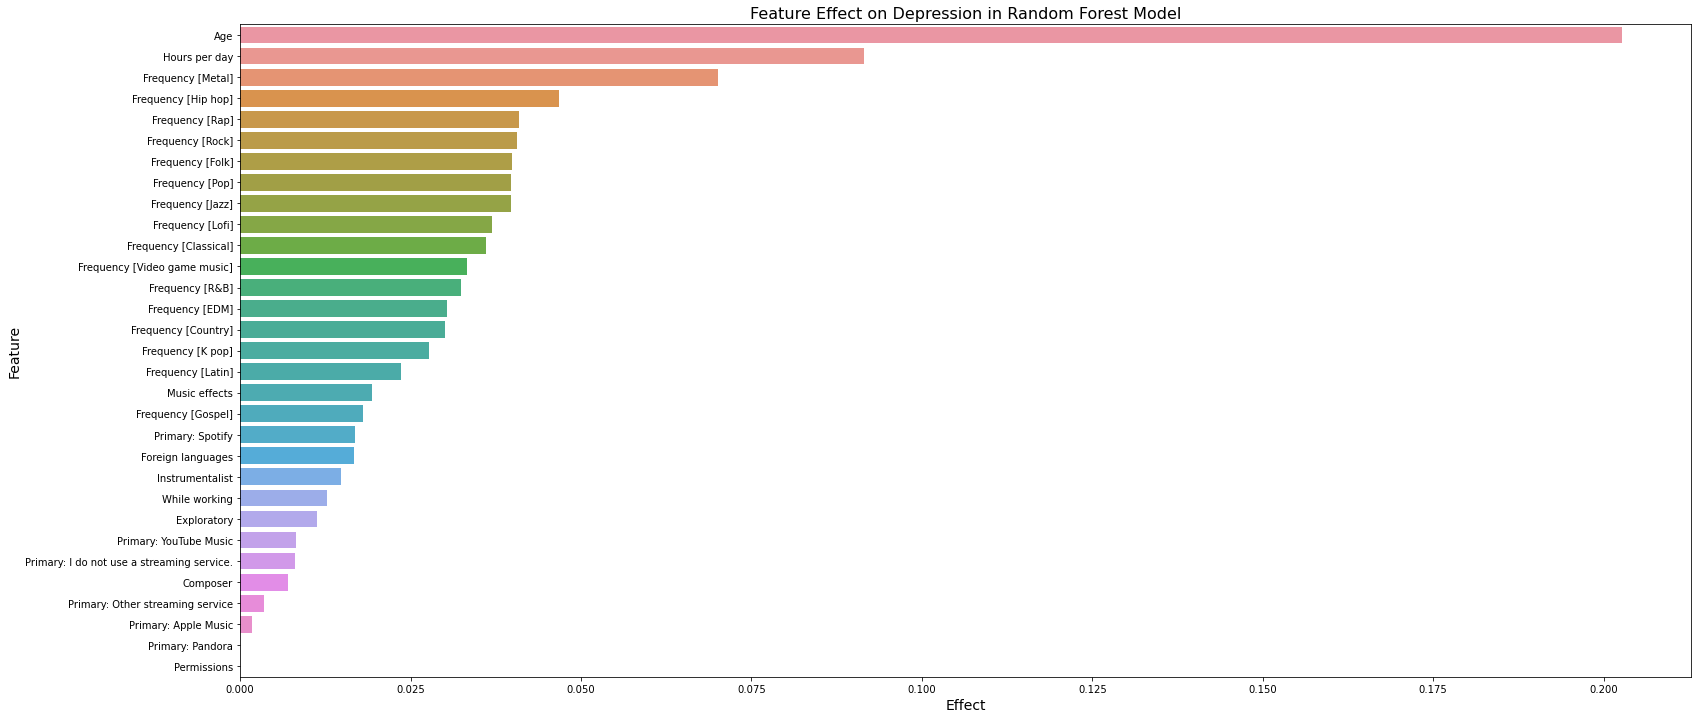

In [657]:
plt.figure(figsize=(26,12))
sns.barplot(y=wtd_features.index, x=wtd_features.weights)
plt.title('Feature Effect on Depression in Random Forest Model', fontsize=16)
plt.xlabel('Effect', fontsize=14)
plt.ylabel('Feature', fontsize=14)